# OLD

In [ ]:
from pathlib import Path
from bids import BIDSLayout
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.interfaces.fmriprep import load_confounds_strategy
import nibabel as nib

In [2]:
# 1) Point to your local BIDS root (with fMRIPrep derivatives present)
bids_root = "/local/anpa/ds003242-1.0.0"
layout = BIDSLayout(bids_root, validate=False, derivatives=True)

/local/anpa/.conda/envs/py39/lib/python3.9/site-packages/bids/layout/validation.py:126: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


In [3]:
layout

BIDS Layout: .../local/anpa/ds003242-1.0.0 | Subjects: 96 | Sessions: 0 | Runs: 575

In [ ]:
# 2) Collect preprocessed BOLD and matching confounds
func_files = layout.get(
    suffix="bold", desc="preproc", extension=[".nii.gz"],
    space="MNI152NLin2009cAsym",  # adjust to your space
    return_type="file", task="CIC"  # or your task
)
func_files

['/local/anpa/ds003242-1.0.0/derivatives/fmriprep/sub-SAXSISO01b/func/sub-SAXSISO01b_task-CIC_run-001_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/local/anpa/ds003242-1.0.0/derivatives/fmriprep/sub-SAXSISO01b/func/sub-SAXSISO01b_task-CIC_run-002_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/local/anpa/ds003242-1.0.0/derivatives/fmriprep/sub-SAXSISO01b/func/sub-SAXSISO01b_task-CIC_run-003_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/local/anpa/ds003242-1.0.0/derivatives/fmriprep/sub-SAXSISO01b/func/sub-SAXSISO01b_task-CIC_run-004_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/local/anpa/ds003242-1.0.0/derivatives/fmriprep/sub-SAXSISO01b/func/sub-SAXSISO01b_task-CIC_run-005_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/local/anpa/ds003242-1.0.0/derivatives/fmriprep/sub-SAXSISO01b/func/sub-SAXSISO01b_task-CIC_run-006_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/local/anpa/ds003242-1.0.0/derivatives/fmriprep/sub-SAXSISO01f/func/

In [7]:
# 3) Choose an atlas (example: Schaefer 200 parcels, 7 networks)
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
atlas_img = atlas.maps
atlas_labels = list(atlas.labels)  # these are the ROI names

[fetch_atlas_schaefer_2018] Added README.md to /home/anpa/nilearn_data
[fetch_atlas_schaefer_2018] Dataset created in /home/anpa/nilearn_data/schaefer_2018
[fetch_atlas_schaefer_2018] Downloading data from https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_200Parcels_7Networks_order.txt ...
[fetch_atlas_schaefer_2018]  ...done. (0 seconds, 0 min)

[fetch_atlas_schaefer_2018] Downloading data from https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz ...
[fetch_atlas_schaefer_2018]  ...done. (0 seconds, 0 min)



In [8]:
atlas_labels

['Background',
 '7Networks_LH_Vis_1',
 '7Networks_LH_Vis_2',
 '7Networks_LH_Vis_3',
 '7Networks_LH_Vis_4',
 '7Networks_LH_Vis_5',
 '7Networks_LH_Vis_6',
 '7Networks_LH_Vis_7',
 '7Networks_LH_Vis_8',
 '7Networks_LH_Vis_9',
 '7Networks_LH_Vis_10',
 '7Networks_LH_Vis_11',
 '7Networks_LH_Vis_12',
 '7Networks_LH_Vis_13',
 '7Networks_LH_Vis_14',
 '7Networks_LH_SomMot_1',
 '7Networks_LH_SomMot_2',
 '7Networks_LH_SomMot_3',
 '7Networks_LH_SomMot_4',
 '7Networks_LH_SomMot_5',
 '7Networks_LH_SomMot_6',
 '7Networks_LH_SomMot_7',
 '7Networks_LH_SomMot_8',
 '7Networks_LH_SomMot_9',
 '7Networks_LH_SomMot_10',
 '7Networks_LH_SomMot_11',
 '7Networks_LH_SomMot_12',
 '7Networks_LH_SomMot_13',
 '7Networks_LH_SomMot_14',
 '7Networks_LH_SomMot_15',
 '7Networks_LH_SomMot_16',
 '7Networks_LH_DorsAttn_Post_1',
 '7Networks_LH_DorsAttn_Post_2',
 '7Networks_LH_DorsAttn_Post_3',
 '7Networks_LH_DorsAttn_Post_4',
 '7Networks_LH_DorsAttn_Post_5',
 '7Networks_LH_DorsAttn_Post_6',
 '7Networks_LH_DorsAttn_Post_7',
 '7N

In [31]:
# 4) Build a labels masker; ROI names will also be available after fit
masker = NiftiLabelsMasker(
    labels_img=atlas_img,
    labels=atlas_labels,
    standardize="zscore_sample",
    detrend=True, t_r=2.0
)

In [32]:
# 5) Loop subjects/runs: load confounds and extract ROI time series
all_timeseries = []
for f in func_files:
    confounds, sample_mask = load_confounds_strategy(
        f, denoise_strategy="simple", motion="basic")
    ts = masker.fit_transform(
        f,
        confounds=confounds,
        sample_mask=sample_mask,
    )
    all_timeseries.append(ts)

In [ ]:
all_timeseries

[array([[-0.97601925,  0.4348108 , -0.01176406, ...,  0.68962677,
          0.25685941,  1.28131813],
        [-1.30837701, -0.60565388, -0.29287172, ..., -1.14705768,
          0.26487235,  1.35870028],
        [-0.45914738, -0.39857139, -0.55166935, ..., -1.77177416,
         -0.12667859, -0.87965964],
        ...,
        [ 0.1138453 ,  0.41029084, -0.43708492, ...,  0.10916981,
          0.74249007,  0.59660127],
        [-0.25367391,  0.01081031,  0.32086926, ..., -1.33936198,
         -0.14340981, -0.01027957],
        [-0.88320673, -0.11478774, -0.42916744, ..., -1.94813882,
         -1.77976682, -1.28878294]]),
 array([[-1.51612177, -1.19703726, -1.76765565, ..., -2.18015362,
         -2.19663182, -0.83078898],
        [-0.45215074, -0.61257907, -0.47028696, ..., -0.10165196,
          0.7912474 ,  0.1031412 ],
        [-0.51059193, -1.16075493, -0.91988999, ..., -0.03648592,
          0.51479864,  0.94743094],
        ...,
        [ 0.51334417, -0.63884773, -1.13255927, ...,  

In [42]:
len(all_timeseries)

573

In [ ]:
import numpy as np

# one big compressed file
np.savez_compressed("all_timeseries.npz", *all_timeseries)

In [35]:
data = np.load("all_timeseries.npz", allow_pickle=True)
all_timeseries_reloaded = [data[k] for k in data]  # back to list of arrays
all_timeseries_reloaded

[array([[-0.97601925,  0.4348108 , -0.01176406, ...,  0.68962677,
          0.25685941,  1.28131813],
        [-1.30837701, -0.60565388, -0.29287172, ..., -1.14705768,
          0.26487235,  1.35870028],
        [-0.45914738, -0.39857139, -0.55166935, ..., -1.77177416,
         -0.12667859, -0.87965964],
        ...,
        [ 0.1138453 ,  0.41029084, -0.43708492, ...,  0.10916981,
          0.74249007,  0.59660127],
        [-0.25367391,  0.01081031,  0.32086926, ..., -1.33936198,
         -0.14340981, -0.01027957],
        [-0.88320673, -0.11478774, -0.42916744, ..., -1.94813882,
         -1.77976682, -1.28878294]]),
 array([[-1.51612177, -1.19703726, -1.76765565, ..., -2.18015362,
         -2.19663182, -0.83078898],
        [-0.45215074, -0.61257907, -0.47028696, ..., -0.10165196,
          0.7912474 ,  0.1031412 ],
        [-0.51059193, -1.16075493, -0.91988999, ..., -0.03648592,
          0.51479864,  0.94743094],
        ...,
        [ 0.51334417, -0.63884773, -1.13255927, ...,  

In [ ]:
# 6) ROI names in the exact column order of 'ts':
roi_names = getattr(masker, "region_names_", None) or getattr(masker, "labels_", atlas_labels)
roi_names

{1: '7Networks_LH_Vis_1',
 2: '7Networks_LH_Vis_2',
 3: '7Networks_LH_Vis_3',
 4: '7Networks_LH_Vis_4',
 5: '7Networks_LH_Vis_5',
 6: '7Networks_LH_Vis_6',
 7: '7Networks_LH_Vis_7',
 8: '7Networks_LH_Vis_8',
 9: '7Networks_LH_Vis_9',
 10: '7Networks_LH_Vis_10',
 11: '7Networks_LH_Vis_11',
 12: '7Networks_LH_Vis_12',
 13: '7Networks_LH_Vis_13',
 14: '7Networks_LH_Vis_14',
 15: '7Networks_LH_SomMot_1',
 16: '7Networks_LH_SomMot_2',
 17: '7Networks_LH_SomMot_3',
 18: '7Networks_LH_SomMot_4',
 19: '7Networks_LH_SomMot_5',
 20: '7Networks_LH_SomMot_6',
 21: '7Networks_LH_SomMot_7',
 22: '7Networks_LH_SomMot_8',
 23: '7Networks_LH_SomMot_9',
 24: '7Networks_LH_SomMot_10',
 25: '7Networks_LH_SomMot_11',
 26: '7Networks_LH_SomMot_12',
 27: '7Networks_LH_SomMot_13',
 28: '7Networks_LH_SomMot_14',
 29: '7Networks_LH_SomMot_15',
 30: '7Networks_LH_SomMot_16',
 31: '7Networks_LH_DorsAttn_Post_1',
 32: '7Networks_LH_DorsAttn_Post_2',
 33: '7Networks_LH_DorsAttn_Post_3',
 34: '7Networks_LH_DorsAttn_

In [ ]:
conn = ConnectivityMeasure(kind="correlation")
connectomes = conn.fit_transform(all_timeseries)

In [39]:
connectomes

array([[[ 1.        ,  0.5706562 ,  0.44900048, ...,  0.52006309,
          0.28085295,  0.26056502],
        [ 0.5706562 ,  1.        ,  0.75732158, ...,  0.16390631,
          0.20123552,  0.21222191],
        [ 0.44900048,  0.75732158,  1.        , ...,  0.29385599,
          0.40075481,  0.42972241],
        ...,
        [ 0.52006309,  0.16390631,  0.29385599, ...,  1.        ,
          0.62607492,  0.53220917],
        [ 0.28085295,  0.20123552,  0.40075481, ...,  0.62607492,
          1.        ,  0.73937749],
        [ 0.26056502,  0.21222191,  0.42972241, ...,  0.53220917,
          0.73937749,  1.        ]],

       [[ 1.        ,  0.41981209,  0.24673179, ...,  0.65280191,
          0.23548805,  0.20425073],
        [ 0.41981209,  1.        ,  0.7089677 , ...,  0.17099993,
          0.04946018, -0.04724017],
        [ 0.24673179,  0.7089677 ,  1.        , ...,  0.18042692,
          0.20456385,  0.10351264],
        ...,
        [ 0.65280191,  0.17099993,  0.18042692, ...,  

In [40]:
connectomes.shape

(573, 200, 200)

In [50]:
import numpy as np
from nilearn import plotting
from nilearn.plotting import find_parcellation_cut_coords

# 1) Fisher-z transform, average across runs/subjects, back to r
C = np.asarray(connectomes)                                    # (n_runs, n_rois, n_rois)
z = np.arctanh(np.clip(C, -0.999999, 0.999999))                # Fisher z
z_mean = z.mean(axis=0)
r_mean = np.tanh(z_mean)                                       # group-average correlation

# 2) ROI labels (same order as your time series)
roi_names = getattr(masker, "region_names_", None) or getattr(masker, "labels_", None)



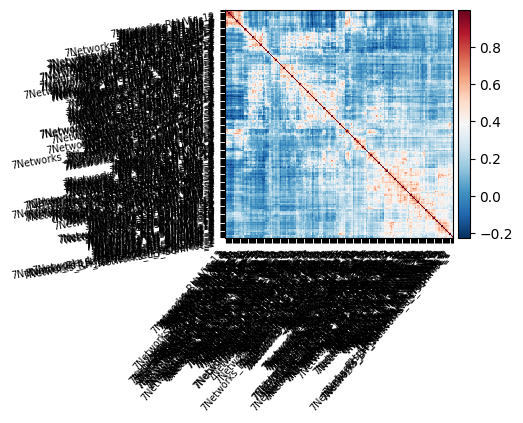

In [51]:
from nilearn import plotting
import numpy as np

# atlas = datasets.fetch_atlas_schaefer_2018(...), same one you used to build the masker
roi_names = list(atlas.labels)
if roi_names and roi_names[0].lower().startswith("background"):
    roi_names = roi_names[1:]          # Schaefer has a 'Background' entry

assert len(roi_names) == r_mean.shape[0] == r_mean.shape[1] == 200
plotting.plot_matrix(r_mean, labels=roi_names, reorder=True, colorbar=True)


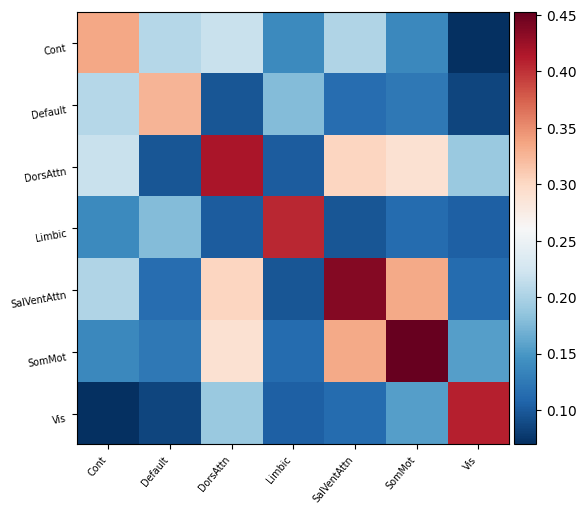

In [48]:
import numpy as np, re
from nilearn import plotting

labs = list(atlas.labels)[1:]  # drop 'Background'
nets = [re.search(r"7Networks_[LR]H_([^_]+)", x).group(1) for x in labs]
uniq = sorted(set(nets))
idx = {n: np.where(np.array(nets)==n)[0] for n in uniq}

net_mat = np.zeros((len(uniq), len(uniq)))
for a, na in enumerate(uniq):
    for b, nb in enumerate(uniq):
        ia, ib = np.ix_(idx[na], idx[nb])
        net_mat[a, b] = r_mean[ia, ib].mean()

plotting.plot_matrix(net_mat, labels=uniq, reorder=False, colorbar=True)


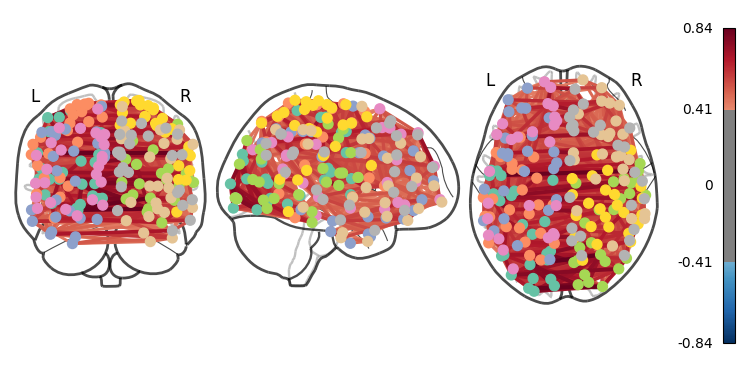

In [49]:
from nilearn.plotting import find_parcellation_cut_coords, plot_connectome
coords = find_parcellation_cut_coords(masker.labels_img_)  # one coord per ROI
plot_connectome(r_mean, coords, edge_threshold="90%")      # strongest edges


# NEW

In [52]:
from pathlib import Path
from bids import BIDSLayout
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.interfaces.fmriprep import load_confounds_strategy
import nibabel as nib

In [53]:
BASE = "/local/anpa/ds003242-1.0.0"
DERIVATIVES = f"{BASE}/derivatives/"
DERIVATIVES_FMRIPREP = f"{DERIVATIVES}/fmriprep/" 